In [16]:
import sys
sys.path.append('C:\\Users\\jkuan\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


In [17]:
# the price at UTC 0 every day
prices = pd.read_csv("data\\commSetTokensprices_Jan2025.csv")

prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace = True, drop = False)
coin = 'Ethereum prices'
end_date = prices["Date"].max()
start_date = end_date - pd.DateOffset(years=3)
eth_last3 = prices[prices["Date"] >= start_date]


In [18]:
eth_prices = eth_last3[coin].values
len(eth_prices)

1097

In [119]:

# -----------------------------
# Black–Scholes helper functions
# -----------------------------
def bs_call_price(S, K, T, r, sigma):
    """
    Price a European call option using the Black–Scholes formula.
    S     : underlying price
    K     : strike price
    T     : time to expiry (in years)
    r     : risk–free rate
    sigma : annualized volatility
    """
    if T <= 0:
        return np.maximum(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_call_delta(S, K, T, r, sigma):
    """
    Compute the delta of a European call option using the Black–Scholes model.
    """
    if T <= 0:
        return np.where(S > K, 1.0, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def simulate_gamma_farming_real_data(prices, dt, K, T, r, sigma, use_threshold=False, threshold=0.1, fee_percent = 0.002):
    """
    Simulate gamma farming (delta hedging) for a single call option trade over its lifetime,
    using actual price data.

    Parameters:
      prices       : underlying prices over the option's lifetime
      dt           : time step in years (e.g., 1/365 for daily data)
      K            : strike price (for an ATM option, K = initial price)
      T            : option tenor in years
      r            : annual risk-free rate
      sigma        : annualized volatility for pricing
      use_threshold: if True, only rebalance when the hedge adjustment exceeds the percentage threshold
      threshold    : the minimum percentage change in delta (as a decimal, e.g., 0.05 for 5%) needed to trigger rebalancing

    Returns:
      option_values, deltas, cash, hedge_positions, port_values
    """
    M = int(T / dt)
    if M >= len(prices):
        raise ValueError("Not enough price data for the option's tenor T.")
    
    # Initialize arrays:
    option_values   = np.zeros(M)
    deltas          = np.zeros(M)
    cash            = np.zeros(M)
    hedge_positions = np.zeros(M)
    port_values     = np.zeros(M)
    value_change_mat = np.zeros(M)
    pure_cash_returns = np.zeros(M)
    # At time 0:
    S0 = prices[0]
    tau = T  # time to expiry at inception
    option_values[0] = bs_call_price(S0, K, tau, r, sigma)
    deltas[0] = bs_call_delta(S0, K, tau, r, sigma)
    
    hedge_positions[0] = -deltas[0]  # Short delta shares of the underlying
    cash[0] = deltas[0] * S0         # Proceeds from shorting the underlying
    port_values[0] = option_values[0] + cash[0] + hedge_positions[0] * S0
    value_change_mat[0] = 0
    just_hedged = True
    pure_cash_returns[0] = 0
    # Delta-hedging loop:
    for i in range(1, M):
        tau = T - i * dt  # remaining time to expiry
        S = prices[i]
        option_values[i] = bs_call_price(S, K, tau, r, sigma)
        deltas[i] = bs_call_delta(S, K, tau, r, sigma)
        
        # Update cash for the mark-to-market of the existing hedge:
        cash[i] = cash[i - 1]
        # Just some debugging print statements
        '''
        if just_hedged == True:
            option_val_change =  option_values[i]-option_values[i-1]
            short_val_change = (prices[i]-prices[i-1])*hedge_positions[i-1]
            value_change = option_val_change + short_val_change
            print(value_change)
            print(option_val_change, short_val_change)
            print(deltas[i-1], hedge_positions[i-1], deltas[i], (prices[i]-prices[i-1]))
        '''
        # Determine the target hedge position (to be delta-neutral):
        target_hedge = -deltas[i]
        
        if use_threshold:
            # Calculate percentage change relative to the previous hedge position:
            if hedge_positions[i - 1] != 0:
                pct_change = abs(target_hedge - hedge_positions[i - 1]) / abs(hedge_positions[i - 1])
            else:
                pct_change = abs(target_hedge)  # if previous hedge is zero, use absolute value
            
            if pct_change > threshold:
                trade = target_hedge - hedge_positions[i - 1]
                cash[i] -= trade * S
                hedge_positions[i] = target_hedge
                just_hedged = True
                if trade > 0:
                    pure_cash_returns[i] =  pure_cash_returns[i-1] + trade * S - trade * S *fee_percent
                else:
                    pure_cash_returns[i] = pure_cash_returns[i-1]

            else:
                # No rebalancing: retain the previous hedge position.
                hedge_positions[i] = hedge_positions[i - 1]
                just_hedged = False
                pure_cash_returns[i] = pure_cash_returns[i - 1]

        else:
            # Always rebalance at every time step.
            trade = target_hedge - hedge_positions[i - 1]
            cash[i] -= trade * S
            hedge_positions[i] = target_hedge
            if trade > 0:
                pure_cash_returns[i] =  pure_cash_returns[i-1] + trade * S - trade * S *fee_percent
            else:
                pure_cash_returns[i] = pure_cash_returns[i-1]


        
        port_values[i] = cash[i] + hedge_positions[i] * S + option_values[i] 
        #print(port_values[i])
    return option_values, deltas, cash, hedge_positions, port_values, pure_cash_returns

# -----------------------------
# Rolling gamma farming simulation over historical data
# -----------------------------
def simulate_rolled_gamma_farming(prices, dt, T, r, sigma):
    """
    Simulate a rolled gamma farming strategy over the full historical price series.
    The idea is to repeatedly enter an ATM call option (with strike = price at trade start)
    with maturity T, delta hedge it over its lifetime, and then roll the trade.
    
    Parameters:
      prices : numpy array of underlying prices over the full period (e.g., 3 years)
      dt     : time step in years (e.g., 1/365 for daily data)
      T      : option maturity in years (e.g., 30/365 for a 30-day option)
      r      : annual risk–free rate
      sigma  : annualized volatility used for option pricing
      
    Returns:
      trades     : list of dictionaries, each containing trade-level P&L and details.
      overall_pnl: total P&L from all trades.
    """
    M = int(T / dt)  # number of time steps per trade
    trades = []
    overall_pnl = 0.0
    i = 0
    trade_number = 0
    while i + M < len(prices):
        trade_prices = prices[i : i + M + 1]
        S0 = trade_prices[0]
        K = S0  # ATM strike
        _, _, _, _, port_vals = simulate_gamma_farming_real_data(trade_prices, dt, K, T, r, sigma)
        trade_pnl = port_vals[-1] - port_vals[0]
        trades.append({
            "trade_number": trade_number,
            "start_index": i,
            "end_index": i + M,
            "initial_value": port_vals[0],
            "final_value": port_vals[-1],
            "pnl": trade_pnl,
            "price_path": trade_prices,
            "portfolio_path": port_vals
        })
        overall_pnl += trade_pnl
        trade_number += 1
        # Roll the trade: start the next trade right after the previous one expires.
        i += M  
    return trades, overall_pnl


def annualized_volatility(prices):
    log_returns = np.log(prices[1:] / prices[:-1])  # Compute daily log returns
    daily_vol = np.std(log_returns)  # Standard deviation of daily returns
    annual_vol = daily_vol * np.sqrt(252)  # Annualize
    return annual_vol



Initial Portfolio Value: 645.65
Final Portfolio Value:   1086.82


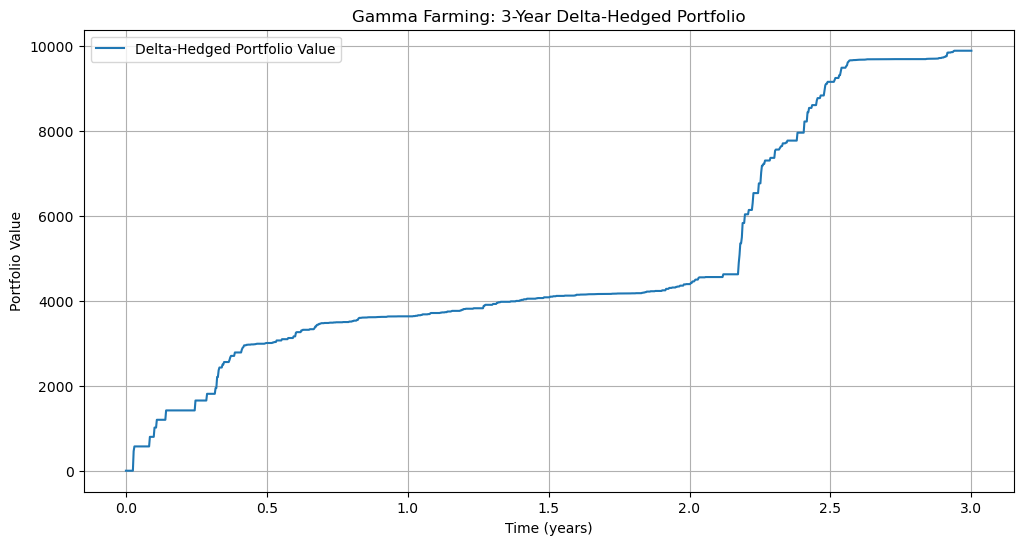

In [120]:

# -----------------------------
# Example usage with Ethereum historical data
# -----------------------------
    
# Assume daily data: dt in years
dt = 1 / 365.0

# Option parameters:
T = 3.0      # 3-year tenor
r = 0.13     # annual risk-free rate (1%)
sigma = 0.3  # assumed annualized volatility for Ethereum (adjust as needed)

# For an OTM option, 50% strike
K = eth_prices[0]*1.5

# Run the gamma farming simulation for the entire 4-year period
option_values, deltas, cash, hedge_positions, port_values, pure_cash_returns = simulate_gamma_farming_real_data(eth_prices, dt, K, T, r, sigma, use_threshold=True, fee_percent = 0.02)

print(f"Initial Portfolio Value: {port_values[0]:.2f}")
print(f"Final Portfolio Value:   {port_values[-1]:.2f}")

# Plot the portfolio value over time
t_grid = np.linspace(0, T, len(port_values))
plt.figure(figsize=(12, 6))
plt.plot(t_grid, pure_cash_returns, label="Delta-Hedged Portfolio Value")
plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Gamma Farming: 3-Year Delta-Hedged Portfolio")
plt.legend()
plt.grid(True)
plt.show()


In [104]:
pure_cash_returns

array([    0.        ,     0.        ,     0.        , ...,
       10071.64705293, 10071.64705293, 10071.64705293])

In [105]:
annualized_volatility(eth_prices)

0.5647164470741352

In [106]:
option_values

array([6.45653321e+002, 7.24601242e+002, 6.50267313e+002, ...,
       2.98279898e-040, 1.69694596e-065, 8.54154482e-153])

In [107]:
bs_call_delta(100, 100, 1, 0.05, 0.2)   # Expected: ~0.5 (ATM option)
bs_call_delta(120, 100, 1, 0.05, 0.2)   # Expected: >0.5 (ITM option)
bs_call_delta(100, 100, 3, 0.13, 0.85)    # Expected: <0.5 (OTM option)


0.8415922718785955

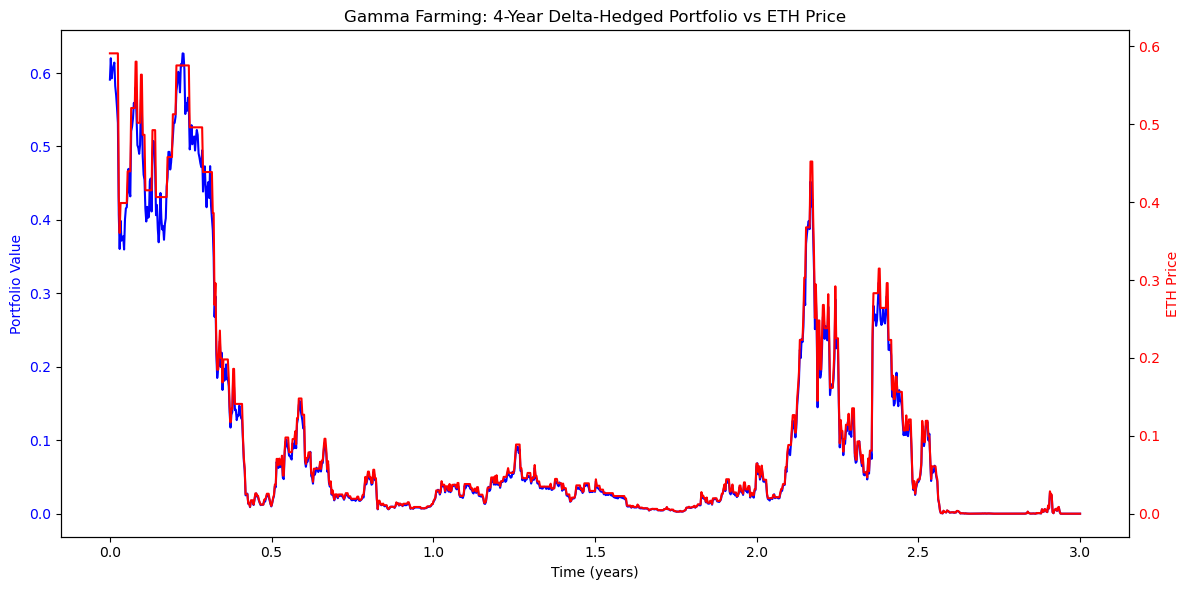

In [108]:
# Create a time grid for plotting
t_grid = np.linspace(0, T, len(port_values))

# Plot both the delta-hedged portfolio value and ETH price against time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot portfolio value on the left y-axis
ax1.plot(t_grid, deltas, 'b-', label="Delta-Hedged Portfolio Value")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Portfolio Value", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot the ETH price
ax2 = ax1.twinx()
ax2.plot(t_grid, -hedge_positions, 'r-', label="ETH Price")
ax2.set_ylabel("ETH Price", color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Gamma Farming: 4-Year Delta-Hedged Portfolio vs ETH Price")
fig.tight_layout()
plt.show()


In [91]:
len(pure_cash_returns)

1095

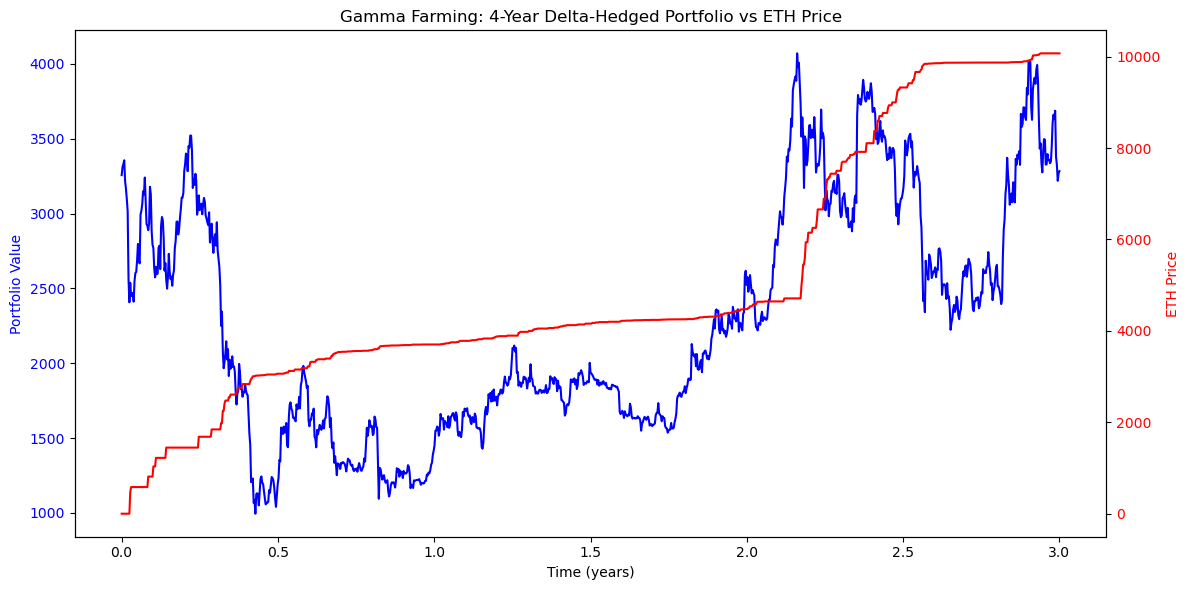

In [109]:
# Create a time grid for plotting
t_grid = np.linspace(0, T, len(port_values))

# Plot both the delta-hedged portfolio value and ETH price against time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot portfolio value on the left y-axis
ax1.plot(t_grid, eth_prices[2:], 'b-', label="Eth Prices")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Portfolio Value", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot the ETH price
ax2 = ax1.twinx()
ax2.plot(t_grid, pure_cash_returns, 'r-', label="Gamma farm amount")
ax2.set_ylabel("ETH Price", color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Gamma Farming: 4-Year Delta-Hedged Portfolio vs ETH Price")
fig.tight_layout()
plt.show()


In [47]:
hedge_positions

array([-5.90971601e-001, -5.90971601e-001, -5.90971601e-001, ...,
       -3.96976582e-066, -4.46443238e-153, -0.00000000e+000])

In [49]:
option_values

array([6.45653321e+002, 7.24601242e+002, 6.50267313e+002, ...,
       1.69694596e-065, 8.54154482e-153, 0.00000000e+000])

In [51]:
deltas[-10:]

array([1.99399136e-015, 7.61790407e-015, 3.98527382e-013, 1.01737920e-013,
       7.73755567e-017, 7.08166616e-019, 4.39534453e-041, 3.96976582e-066,
       4.46443238e-153, 0.00000000e+000])

In [52]:
K

4869.6205845

In [47]:
import math

def dumb_hedge_function(initial_price, current_price):
    """
    Returns a value in [0, 1], starting at 0.5 when current_price == initial_price,
    rising toward 1 for large price increases, and decreasing toward 0 for large price drops.
    """
    # Handle the trivial case of zero or negative initial prices safely:
    if initial_price <= 0:
        raise ValueError("initial_price must be positive.")
    
    r = current_price / initial_price
    
    # If the ratio is exactly 1
    if r == 1:
        return 0.5
    
    # If the ratio is above 1, use the "moving closer to 1" formula
    elif r > 1:
        return 1.0 - 0.5 * (0.9 ** (math.log(r) / math.log(1.1)))
    
    # Otherwise the ratio is below 1, use the "moving closer to 0" formula
    else:
        # If r <= 0, you might decide how you want to handle that; for now, treat similarly.
        if r <= 0:
            # You could cap it at 0, raise an error, etc.
            return 0.0
        return 0.5 * (0.9 ** (math.log(r) / math.log(0.9)))

# Example usage:
initial_price = 100
current_price = 1  # 10% increase
print(dumb_hedge_function(initial_price, current_price))  # Should be slightly less than 0.5


0.005000000000000004


In [97]:
def dumb_gamma_farming_real_data(prices, dt, K, T, r, sigma, use_threshold=False, threshold=0.1):
    M = int(T / dt)
    if M >= len(prices):
        raise ValueError("Not enough price data for the option's tenor T.")
    
    # Initialize arrays:
    option_values   = np.zeros(M)
    deltas          = np.zeros(M)
    hedge_positions = np.zeros(M)
    value_change_mat = np.zeros(M)
    pure_cash_returns_perps = np.zeros(M)
    pure_cash_returns_short = np.zeros(M)

    # At time 0:
    S0 = prices[0]
    hedgePrice = S0
    tau = T  # time to expiry at inception
    option_values[0] = bs_call_price(S0, K, tau, r, sigma)
    deltas[0] = 0.5
    
    hedge_positions[0] = -deltas[0]  # Short delta shares of the underlying
    value_change_mat[0] = 0
    just_hedged = True
    pure_cash_returns_perps[0] = 0
    pure_cash_returns_short[0] = deltas[0] * S0
    # Delta-hedging loop:
    for i in range(1, M):
        tau = T - i * dt  # remaining time to expiry
        S = prices[i]
        option_values[i] = bs_call_price(S, K, tau, r, sigma)
        if (abs(hedgePrice - S)/hedgePrice) > 0.2:
            hedgePrice = S
        deltas[i] = dumb_hedge_function(hedgePrice, S)
        # Determine the target hedge position (to be delta-neutral):
        target_hedge = -deltas[i]
        
        if use_threshold:
            # Calculate percentage change relative to the previous hedge position:
            if hedge_positions[i - 1] != 0:
                pct_change = abs(target_hedge - hedge_positions[i - 1]) / abs(hedge_positions[i - 1])
            else:
                pct_change = abs(target_hedge)  # if previous hedge is zero, use absolute value
            
            if pct_change > threshold:
                trade = target_hedge - hedge_positions[i - 1]
                hedge_positions[i] = target_hedge
                just_hedged = True
                if trade > 0:
                    pure_cash_returns_perps[i] =  pure_cash_returns_perps[i-1] + trade * S
                    pure_cash_returns_short[i] = pure_cash_returns_short[i-1]
                else:
                    pure_cash_returns_perps[i] = pure_cash_returns_perps[i-1]
                    pure_cash_returns_short[i] = pure_cash_returns_short[i-1] - trade * S

            else:
                # No rebalancing: retain the previous hedge position.
                hedge_positions[i] = hedge_positions[i - 1]
                pure_cash_returns_short[i] = pure_cash_returns_short[i-1]
                pure_cash_returns_perps[i] = pure_cash_returns_perps[i-1]

        else:
            # Always rebalance at every time step.
            trade = target_hedge - hedge_positions[i - 1]
            hedge_positions[i] = target_hedge
            if trade > 0:
                pure_cash_returns_perps[i] =  pure_cash_returns_perps[i-1] + trade * S
                pure_cash_returns_short[i] = pure_cash_returns_short[i-1]
            else:
                pure_cash_returns_perps[i] = pure_cash_returns_perps[i-1]
                pure_cash_returns_short[i] = pure_cash_returns_short[i-1] - trade * S
        
        unhedgeAmount = hedge_positions[-1]
        pure_cash_returns_short[-1] = pure_cash_returns_short[-1] + unhedgeAmount*S

    return option_values, deltas, hedge_positions, pure_cash_returns_perps, pure_cash_returns_short


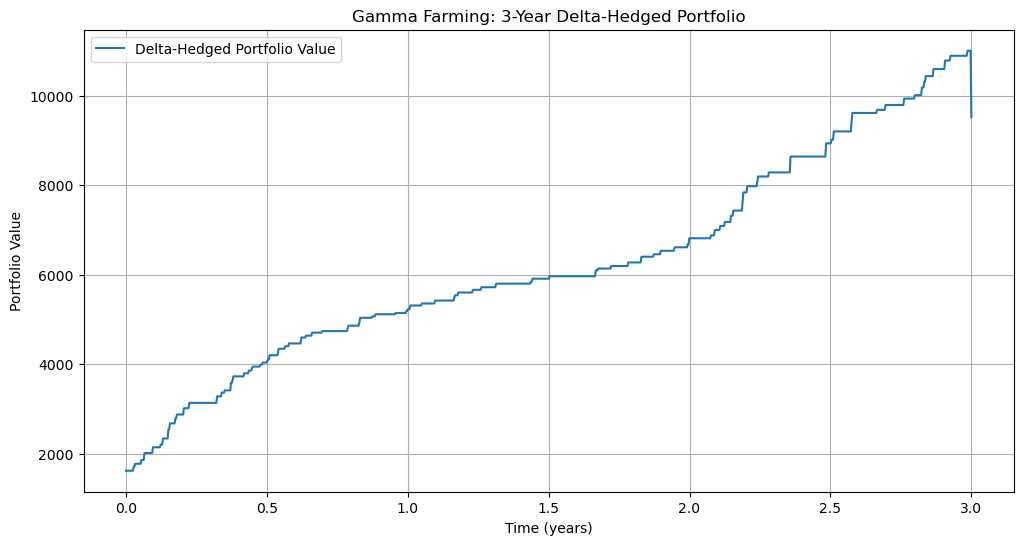

In [98]:
# Assume daily data: dt in years
dt = 1 / 365.0

# Option parameters:
T = 3.0      # 3-year tenor
r = 0.13     # annual risk-free rate (1%)
sigma = 0.3  # assumed annualized volatility for Ethereum (adjust as needed)

# For an OTM option, 50% strike
K = eth_prices[0]*1.5

# Run the gamma farming simulation for the entire 4-year period
option_values, deltas, hedge_positions, pure_cash_returns_perps, pure_cash_returns_short = dumb_gamma_farming_real_data(eth_prices, dt, K, T, r, sigma, use_threshold=True, threshold = 0.05)


# Plot the portfolio value over time
t_grid = np.linspace(0, T, len(pure_cash_returns_short))
plt.figure(figsize=(12, 6))
plt.plot(t_grid, pure_cash_returns_short, label="Delta-Hedged Portfolio Value")
plt.xlabel("Time (years)")
plt.ylabel("Portfolio Value")
plt.title("Gamma Farming: 3-Year Delta-Hedged Portfolio")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
M = int(T / dt)
if M >= len(prices):
    raise ValueError("Not enough price data for the option's tenor T.")

# Initialize arrays:
option_values   = np.zeros(M)
deltas          = np.zeros(M)
cash            = np.zeros(M)
hedge_positions = np.zeros(M)
port_values     = np.zeros(M)
value_change_mat = np.zeros(M)
pure_cash_returns = np.zeros(M)
# At time 0:
S0 = prices[0]
tau = T  # time to expiry at inception
option_values[0] = bs_call_price(S0, K, tau, r, sigma)
deltas[0] = bs_call_delta(S0, K, tau, r, sigma)

hedge_positions[0] = -deltas[0]  # Short delta shares of the underlying
cash[0] = deltas[0] * S0         # Proceeds from shorting the underlying
port_values[0] = option_values[0] + cash[0] + hedge_positions[0] * S0
value_change_mat[0] = 0
just_hedged = True
pure_cash_returns[0] = 0
# Delta-hedging loop:
for i in range(1, M):
    tau = T - i * dt  # remaining time to expiry
    S = prices[i]
    option_values[i] = bs_call_price(S, K, tau, r, sigma)
    deltas[i] = bs_call_delta(S, K, tau, r, sigma)

    # Update cash for the mark-to-market of the existing hedge:
    cash[i] = cash[i - 1]
    # Just some debugging print statements
    '''
    if just_hedged == True:
        option_val_change =  option_values[i]-option_values[i-1]
        short_val_change = (prices[i]-prices[i-1])*hedge_positions[i-1]
        value_change = option_val_change + short_val_change
        print(value_change)
        print(option_val_change, short_val_change)
        print(deltas[i-1], hedge_positions[i-1], deltas[i], (prices[i]-prices[i-1]))
    '''
    # Determine the target hedge position (to be delta-neutral):
    target_hedge = -deltas[i]

    if use_threshold:
        # Calculate percentage change relative to the previous hedge position:
        if hedge_positions[i - 1] != 0:
            pct_change = abs(target_hedge - hedge_positions[i - 1]) / abs(hedge_positions[i - 1])
        else:
            pct_change = abs(target_hedge)  # if previous hedge is zero, use absolute value

        if pct_change > threshold:
            trade = target_hedge - hedge_positions[i - 1]
            cash[i] -= trade * S
            hedge_positions[i] = target_hedge
            just_hedged = True
            if trade > 0:
                pure_cash_returns[i] =  pure_cash_returns[i-1] + trade * S - trade * S *fee_percent
            else:
                pure_cash_returns[i] = pure_cash_returns[i-1]

        else:
            # No rebalancing: retain the previous hedge position.
            hedge_positions[i] = hedge_positions[i - 1]
            just_hedged = False
            pure_cash_returns[i] = pure_cash_returns[i - 1]

    else:
        # Always rebalance at every time step.
        trade = target_hedge - hedge_positions[i - 1]
        cash[i] -= trade * S
        hedge_positions[i] = target_hedge
        if trade > 0:
            pure_cash_returns[i] =  pure_cash_returns[i-1] + trade * S - trade * S *fee_percent
        else:
            pure_cash_returns[i] = pure_cash_returns[i-1]



    port_values[i] = cash[i] + hedge_positions[i] * S + option_values[i] 
    #print(port_values[i])
return option_values, deltas, cash, hedge_positions, port_values, pure_cash_returns
